In [1]:
# activiate inline plotting
%matplotlib inline
from setup import *

# Tutorial on how to simulate genetic associations based on HapMap data

This tutorial demonstrates how genotype data can be used to generate simulated phenotpye datasetes.

In [2]:
# load 1000g data:

#load 1000 genomes data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
genotype_file = tutorial_data.get_file('1000g')
annotation_file = tutorial_data.get_file('1000g_annotation')
geno_reader_1000G  = gr.genotype_reader_tables(genotype_file)
#read annotation
fa = h5py.File(annotation_file,'r')
population_1000G = fa['Population'][:]
pos_1000G = geno_reader_1000G.getPos()

#select YRI and CEU populations
Ipop = (population_1000G=='CEU') | (population_1000G=='YRI') | (population_1000G=='GBR') | (population_1000G=='FIN')
population_1000G = population_1000G[Ipop]
M1000G = geno_reader_1000G.getGenotypes()[Ipop]

# atwell 107
file_name = tutorial_data.get_file('arab107')
geno_reader_atwell  = gr.genotype_reader_tables(file_name)
Matwell = geno_reader_atwell.getGenotypes()
posatwell = geno_reader_atwell.getPos()
Matwell = Matwell[:,::10]
Matwell = Matwell[0:200,:]
posatwell = posatwell[::10]

# ByXRM
file_name = tutorial_data.get_file('BYxRM')
geno_reader_BYxRM  = gr.genotype_reader_tables(file_name)
# M is a binary matrix [samples,genotypes]
MBYxRM = geno_reader_BYxRM.getGenotypes()
posBYxRM = geno_reader_BYxRM.getPos()





In [3]:
if 0:
    M = M1000G
    POS = pos_1000G
    minor_allele=2
    
if 1:
    M = Matwell
    POS = posatwell
    minor_allele=1
    
if 0:
    M= MBYxRM
    POS = posBYxRM
    minor_allele=1

In [4]:

#M1000G = geno_reader_1000G.getGenotypes()

#note: the 1000g samples have different populational background.
#a subset of the samples are YRI and the remaining CEU
#you can query this information using the array "popuatlion_1000G"

#filter by allele frequency
af = calc_AF(M,minor=minor_allele)
Iok = (af['af']>=0.05) & ((af['af']<0.95))
M = M[:,Iok]
POS = POS[Iok]


In [5]:
N = M.shape[0]
#set random seed to make this reporducible
sp.random.seed(5)

snps = sp.array(M,dtype='float')
#specifiy number of causal variants and total variance attributable to genetic effects
#10% are causal genetic effects
Vfg = 0.2
#variance due to non-causal population structure
Vbg = 0.3
#noise
Vresidual = 1.0-Vbg-Vfg
#number of causal loci and polygenic signal of population structure
Nfg = 5
#background:
Nbg = 10

#random selection of SNPs
Irandom = sp.random.permutation(M.shape[1])
i_snp =0

#simulate population structure effects
W_bg = sp.randn(Nbg)

#and causal loci
W_fg = sp.randn(Nfg)

#simulate random noise
y_residual = sp.randn(N)

#background snps (weak)
I_bg = Irandom[i_snp:i_snp+Nbg]
snps_bg  = snps[:,I_bg]
snps_bg -= snps_bg.mean(axis=0)
snps_bg /= snps_bg.std(axis=0)
y_bg     = sp.dot(snps_bg,W_bg)
i_snp+=Nbg

#foreground SNPs (strong)
I_fg = Irandom[i_snp:i_snp+Nfg]
snps_fg = snps[:,I_fg]
snps_fg -= snps_fg.mean(axis=0)
snps_fg /= snps_fg.std(axis=0)
y_fg      = sp.dot(snps_fg,W_fg)
i_snp+=Nfg

#
I_causal = sp.concatenate([I_fg,I_bg])

#normalize and add up
y =   y_fg/y_fg.std()*sp.sqrt(Vfg) 
y +=  y_bg/y_bg.std()*sp.sqrt(Vbg)
y +=  y_residual/y_residual.std()*sp.sqrt(Vresidual)
y = y[:,sp.newaxis]


In [6]:

#run gwas:
covs = None
test = 'lrt'
lm = qtl.test_lm(snps=snps,pheno=y,
                   covs=covs, test=test)

K = sp.dot(snps,snps.T)
K /= K.diagonal().mean()

lmm = qtl.test_lmm(snps=snps,pheno=y,K=K,
                   covs=covs, test=test)
pos = POS['pos'].values
pv_lmm  = lmm.getPv().ravel()
pv      = lm.getPv().ravel()

## QTL scan on the simulated dataset

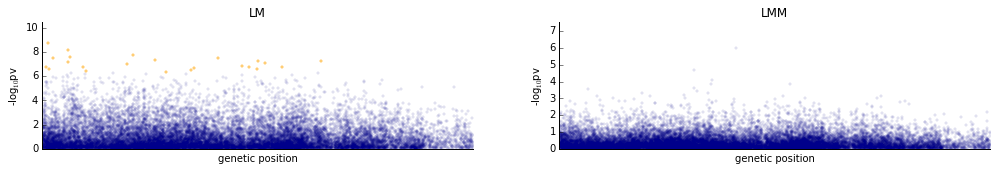

In [7]:
pl.figure(figsize=[17,5])
plt.subplot(2,2,1)
# Genome-wide manhatton plots for one phenotype:
pos = POS['pos'].values
plot_manhattan(pos,pv)
pl.title('LM')
plt.subplot(2,2,2)
pos = POS['pos'].values
plot_manhattan(pos,pv_lmm)
pl.title('LMM')



What are the loci that are being discovered. Are all associations found by LM background signals or SNPs with a large effect?

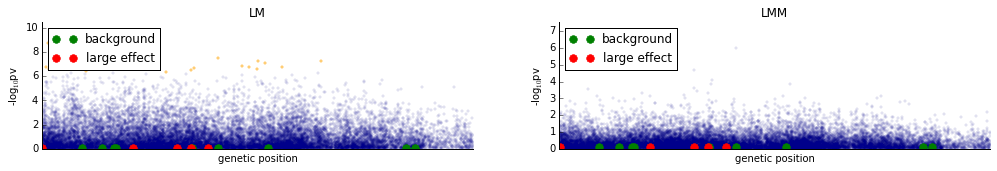

In [8]:
pl.figure(figsize=[17,5])
plt.subplot(2,2,1)
# Genome-wide manhatton plots for one phenotype:
pos = POS['pos'].values
plot_manhattan(pos,pv)
#plot causal loci and background loci
pl.plot(pos[I_bg],0.1*sp.ones(len(I_bg)),'g.',markersize=15,label='background')
pl.plot(pos[I_fg],0.1*sp.ones(len(I_fg)),'r.',markersize=15,label='large effect')
pl.legend(loc='upper left')
pl.title('LM')
plt.subplot(2,2,2)
plot_manhattan(pos,pv_lmm)
#plot causal loci and background loci
pl.plot(pos[I_bg],0.1*sp.ones(len(I_bg)),'g.',markersize=15,label='background')
pl.plot(pos[I_fg],0.1*sp.ones(len(I_fg)),'r.',markersize=15,label='large effect')
pl.legend(loc='upper left')
pl.title('LMM')

#Observation
* Population structure results in associations at non-causal loci (neither background nor foreground).
* The LMM effectively corrects for structure such that causal loci stand out to a greater extent.
* The power to detect causal loci (sensitivity) of the LMM decreases. 

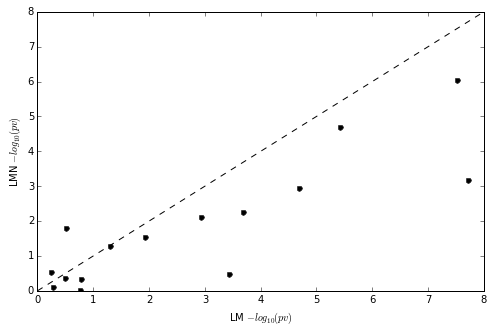

In [9]:
pl.figure(figsize=[8,5])
pl.plot(-sp.log10(pv[I_causal]),-sp.log10(pv_lmm[I_causal]),'k.',markersize=10)
maxx = max(pl.xlim()[1],pl.ylim()[1])
pl.plot([0,maxx],[0,maxx],'k--')
pl.xlabel('LM $-log_{10}(pv)$')
pl.ylabel('LMN $-log_{10}(pv)$')

#Stepwise association analysis
* Stepwise inclusion of lead SNPs into the model


In [10]:
alpha = 0.05/snps.shape[1]
lmm,RV = qtl.forward_lmm(snps=snps,pheno=y,K=K,
                   covs=covs, test=test,threshold=alpha,maxiter=10)


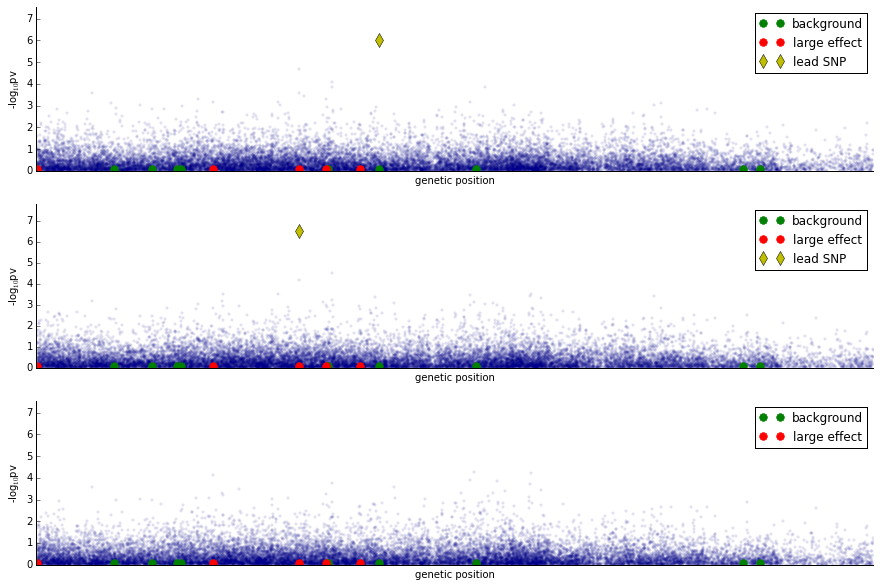

In [11]:
pl.figure(figsize=[15,10])
Nadded = RV['pvall'].shape[0]

for i in xrange(Nadded):
    plt.subplot(Nadded,1,1+i)
    pv = RV['pvall'][i]
    plot_manhattan(pos,pv)
    pl.plot(pos[I_bg],0.1*sp.ones(len(I_bg)),'g.',markersize=15,label='background')
    pl.plot(pos[I_fg],0.1*sp.ones(len(I_fg)),'r.',markersize=15,label='large effect')
    
    #mark the most associated SNP
    if i<(Nadded-1):
        pl.plot(pos[RV['iadded'][i]],-sp.log10(pv)[RV['iadded'][i]],'dy',markersize=10,label='lead SNP')    
    pl.legend(loc='upper right')



## observations
* Nearby associaations can be dissected into individual causal signals (allelic heterogeneity).
* Secondary associations can get stronger by conditioning on nearby SNPs.

# Heritability estimation

In [12]:
# variance component model
vc = var.VarianceDecomposition(y)
vc.addFixedEffect()
vc.addRandomEffect(K=K)
vc.addRandomEffect(is_noise=True)
vc.optimize()
    
_var = vc.getVarianceComps()
_var /= _var.sum()
_var = _var.ravel()
print 'genetic: %.2f, noise: %.2f' % (_var[0],_var[1])

genetic: 0.63, noise: 0.37


In [13]:
# variance component model
I_non_causal = sp.arange(snps.shape[1])
I_non_causal = sp.setdiff1d(I_non_causal,I_causal)

K_causal = sp.dot(snps[:,I_causal],snps[:,I_causal].T)
K_noncausal = sp.dot(snps[:,I_non_causal],snps[:,I_non_causal].T)

vc = var.VarianceDecomposition(y)
vc.addFixedEffect()
vc.addRandomEffect(K=K_causal)
vc.addRandomEffect(K=K_noncausal)
vc.addRandomEffect(is_noise=True)
vc.optimize()
    
_var = vc.getVarianceComps()
_var /= _var.sum()
_var = _var.ravel()
print 'genetic: %.2f, non causal: %.2f, noise: %.2f' % (_var[0],_var[1],_var[2])

genetic: 0.67, non causal: 0.00, noise: 0.33


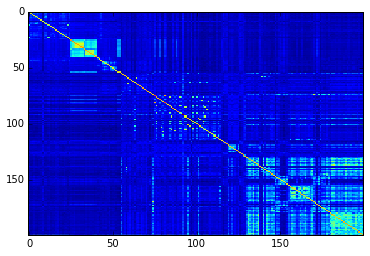

In [14]:
pl.imshow(K_causal,aspect='auto',interpolation='none')
pl.imshow(K_noncausal,aspect='auto',interpolation='none')
